In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import houses as ho
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
df2 = pd.read_csv('datasets/house_train_raw.csv')

In [3]:
df, numerical, cat_ord = ho.transform(df2, 0)

Mejor grado polinomial

In [4]:
error = np.zeros((10,1))

for i in range(1,11):
    # get the locations
    
    X = df.drop(columns='SalePrice', axis=1).copy()
    # Aplicamos normalizacion de los datos
    X.loc[:, numerical], mu, sigma = ho.featureNormalize(X.loc[:,numerical])

    #X = df.loc[:, numerical+cat_ord]
    
    y = df.loc[:, 'SalePrice']

    grado = i
    
    for feature in numerical+cat_ord:
        X = pd.concat([X, ho.polyFeatures(X[feature],grado).loc[:,1:]], axis=1)

    # get x_train and y_train
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.4, random_state=2)


    x_t = np.array(X_train)
    y_t = np.array(y_train)


    reg = LinearRegression().fit(x_t, y_t)

    predict = reg.predict(X_val.values)

    error[i-1] = ho.rmsle(predict, y_val)

In [5]:
error

array([[0.14448587],
       [0.14780198],
       [0.14745747],
       [0.14163582],
       [0.14574742],
       [0.14200445],
       [0.14610267],
       [0.14252895],
       [0.16543332],
       [0.19250647]])

In [6]:
# get the locations
X = df.drop(columns='SalePrice', axis=1).copy()
#X = df.loc[:, numerical+cat_ord]
y = df.loc[:, 'SalePrice'].copy()

# Aplicamos normalizacion de los datos
X.loc[:, numerical], mu, sigma = ho.featureNormalize(X.loc[:,numerical])

grado = 4
for feature in numerical: #+cat_ord:
    X = pd.concat([X, ho.polyFeatures(X[feature],grado).loc[:,1:]], axis=1).copy()

grado = 2
for feature in cat_ord: #+cat_ord:
    X = pd.concat([X, ho.polyFeatures(X[feature],grado).loc[:,1:]], axis=1).copy()
#X['constant'] = 1

# get x_train and y_train
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.4, random_state=2)

x_t = np.array(X_train)
y_t = np.array(y_train)

Entrenamiento

In [7]:
reg = LinearRegression().fit(x_t, y_t)
#theta = ho.normalEqn(x_t, y_t)

In [8]:
#predict = np.matmul(X_val, theta)
predict = reg.predict(X_val.values)

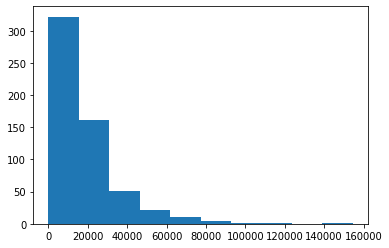

In [9]:
plt.hist(sorted(np.absolute(predict - y_val)))
plt.show()

In [10]:
ho.rmsle(predict, y_val)

0.13968618204137165

Curvas de aprendizaje

In [11]:
z = 40
m = X_train.shape[0]
j_train = np.zeros((m-z,1))
j_val = np.zeros((m-z,1))

for sample_size in range(z,m,20):

    sample_x = x_t[:sample_size,:]
    sample_y = y_t[:sample_size]

    #------------------------------------------------
    # entrenar modelo
    reg = LinearRegression().fit(sample_x, sample_y)

    # evaluar modelo en conjunto de entrenamiento y validacion.
    prediction_train = reg.predict(sample_x)
    prediction_val = reg.predict(X_val.values)
    #--------------------------------------------

    #theta = ho.normalEqn(sample_x, sample_y)
##
    ## evaluar modelo en conjunto de entrenamiento y validacion.
    #prediction_train = np.matmul(sample_x, theta)
    #prediction_val = np.matmul(X_val, theta)


    # obtener el error en los conjuntos de entrenamiento y validacion
    j_train[sample_size-z] = ho.rmsle(prediction_train, sample_y)
    j_val[sample_size-z] = ho.rmsle(prediction_val, y_val)

    

c:\Users\exort\Documents\Code\Henry\Hackathon\Hackathon-house-price\houses.py:202: RuntimeWarning: invalid value encountered in log
  z = (np.log(predict+1) - np.log(actual+1))**2
c:\Users\exort\Documents\Code\Henry\Hackathon\Hackathon-house-price\houses.py:202: RuntimeWarning: invalid value encountered in log
  z = (np.log(predict+1) - np.log(actual+1))**2
c:\Users\exort\Documents\Code\Henry\Hackathon\Hackathon-house-price\houses.py:202: RuntimeWarning: invalid value encountered in log
  z = (np.log(predict+1) - np.log(actual+1))**2
c:\Users\exort\Documents\Code\Henry\Hackathon\Hackathon-house-price\houses.py:202: RuntimeWarning: invalid value encountered in log
  z = (np.log(predict+1) - np.log(actual+1))**2
c:\Users\exort\Documents\Code\Henry\Hackathon\Hackathon-house-price\houses.py:202: RuntimeWarning: invalid value encountered in log
  z = (np.log(predict+1) - np.log(actual+1))**2
c:\Users\exort\Documents\Code\Henry\Hackathon\Hackathon-house-price\houses.py:202: RuntimeWarning: i

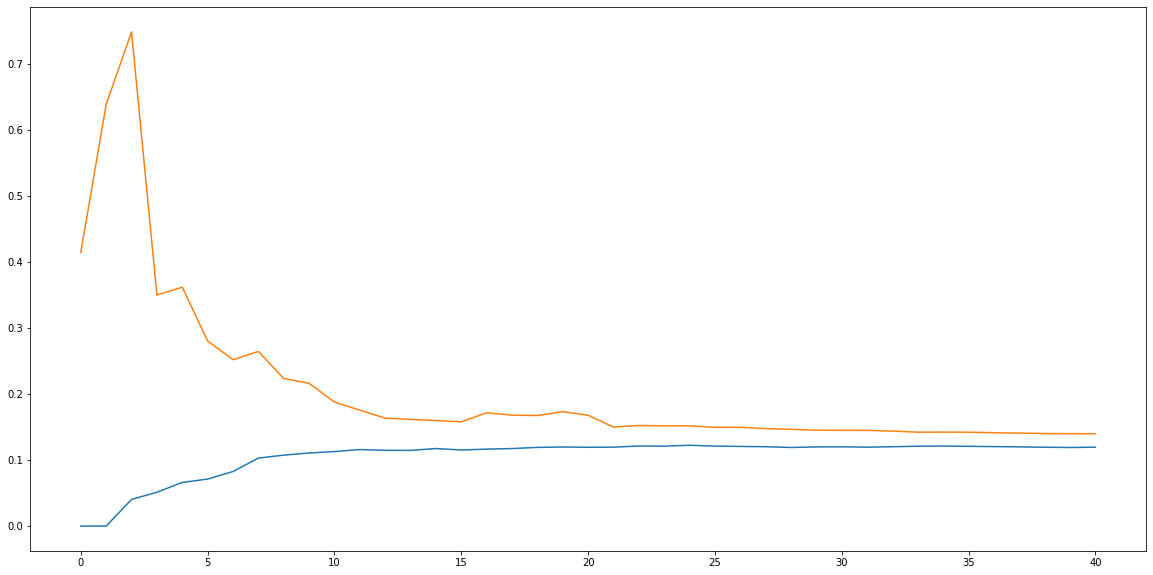

In [12]:
plt.figure(figsize=(20,10))
plt.plot(j_train[j_train!=0])
plt.plot(j_val[j_val!=0])
plt.show()

Guardar modelo

In [19]:
import joblib
joblib.dump(reg, 'LinearRegression_house.pkl')

['LinearRegression_house.pkl']

Llenar csv de test

In [20]:
test_data = pd.read_csv('datasets/houses_test_raw.csv')
test_data['SalePrice'] = 1

test, numerical, cat_ord = ho.transform(test_data, 0)
test = test.iloc[:,test.columns != 'SalePrice']

# aplicamos la normalizacion
test.loc[:,numerical] = (test.loc[:,numerical]-np.transpose(mu))/ np.transpose(sigma)

# Agregamos las variables de segundo grado
grado = 4
for feature in numerical: #+cat_ord:
    test = pd.concat([test, ho.polyFeatures(test[feature],grado).loc[:,1:]], axis=1).copy()

grado = 2
for feature in cat_ord: #+cat_ord:
    test = pd.concat([test, ho.polyFeatures(test[feature],grado).loc[:,1:]], axis=1).copy()
#X['constant'] = 1

test_array = np.array(test)

In [29]:
# Cargar modelo
reg = joblib.load('LinearRegression_house.pkl')

# get predict
predict = reg.predict(test_array)
pd.DataFrame(predict, columns=['pred']).to_csv('pred_test.csv', index=False)